In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from keras import Sequential
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json

1.0 Data acquisition

In [3]:
training_data_path = '/Users/godfreykrutzsch/Desktop/digit-recognizer/train.csv'
testing_data_path = '/Users/godfreykrutzsch/Desktop/digit-recognizer/test.csv'

training_data = pd.read_csv(training_data_path)
testing_data = pd.read_csv(testing_data_path)

In [4]:
print(training_data)
print(training_data.shape)
print(testing_data)

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775 

2.0 Sample Images

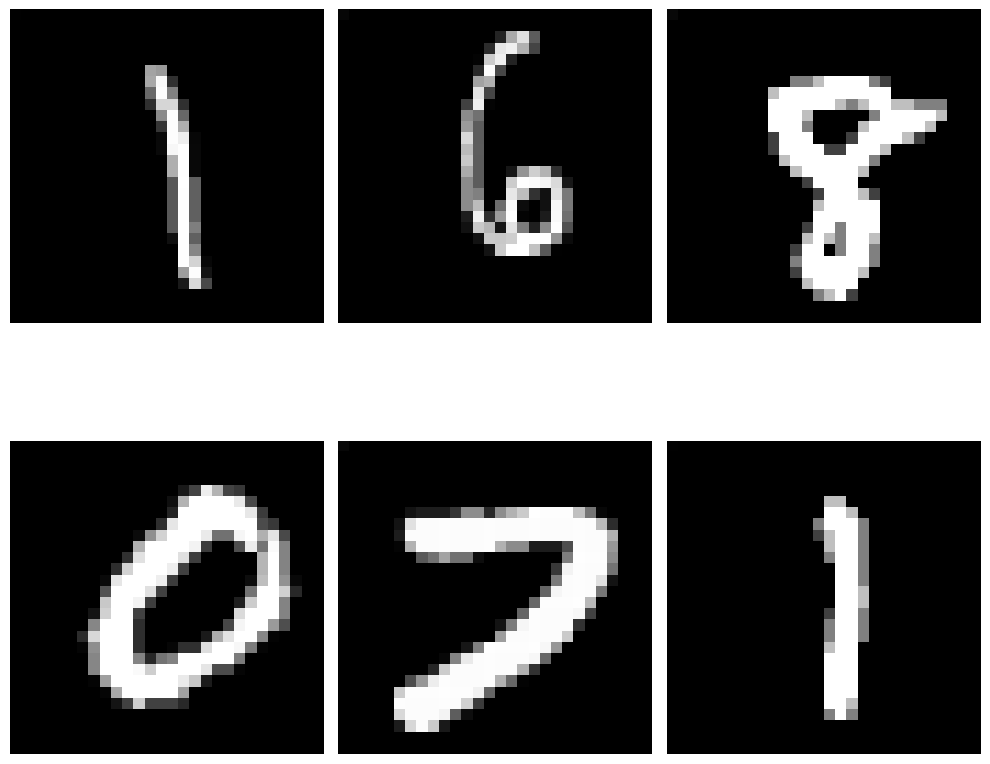

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))

# Loop over each subplot and display a random image
for i in range(2):  # Loop over the rows of subplots
    for j in range(3):  # Loop over the columns of subplots
        random_index = random.randint(0, training_data.shape[0] - 1)  # Random index
        
        # Get the flattened image (first 784 columns) and reshape it to 28x28
        random_image = training_data.iloc[random_index, :-1].values.reshape(28, 28)  # Exclude the label column
        
        ax[i, j].imshow(random_image, cmap='gray')  # Display the reshaped image
        ax[i, j].axis('off')  # Hide the axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

3.0 Dataset Exploration

3.1 Training data

In [6]:
print(f"Total rows: {training_data.shape[0]}")

Total rows: 42000


In [7]:
print(f" Features: {len(training_data.columns)}")

 Features: 785


In [8]:
print(f" information: {training_data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
 information: None


3.2 Testing data

In [9]:
print(f" Total rows: {testing_data.shape[0]}")

 Total rows: 28000


In [10]:
print(f" features: {len(testing_data.columns)}")

 features: 784


In [11]:
print(f" information: {testing_data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
 information: None


In [12]:
print(training_data.columns)
print(training_data.shape)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
(42000, 785)


4.0 Dependent Features

AttributeError: 'numpy.int64' object has no attribute 'startswith'

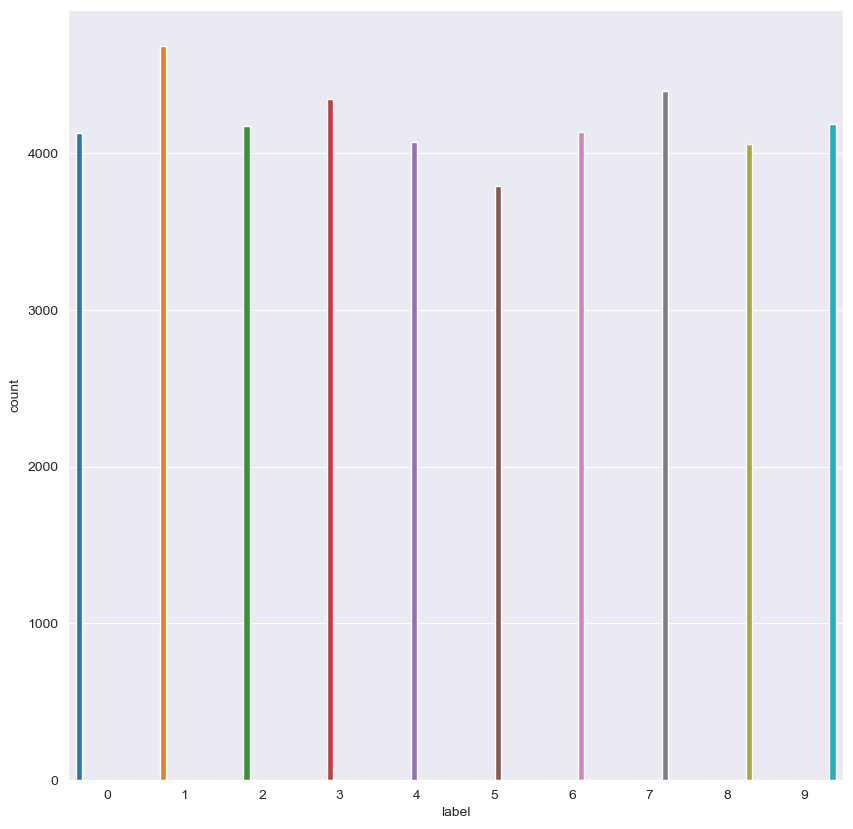

In [13]:
plt.figure(figsize=(10, 10))
sns.countplot(training_data, x='label',hue='label')
plt.title("Labels distribution", size=16)
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


5.0 Data processing for machine learning pipeline image classification for CNNs

5.1 Split data into dependent and independent features

In [14]:
# split the target variable from the other features
X = training_data.drop(columns=['label']).values # variables
Y = training_data['label'].values # target or dependent variable 
print(len(Y))
print(len(X))

42000
42000


5.2 Reshape the data

In [15]:
# reshape the flattened  784 back to their original 2D form (28x 28 pixels per image) and add 1 for grayscale (with other images its RGB 3) but the MNIST spec.
# we must reshape if we intend to use a CNN E.G. They expect 4 dimensions samples, height, width, channel the -1 works this out automatically.
X_train = np.reshape(X, (-1, 28, 28, 1))

In [16]:
print(X_train.shape)

(42000, 28, 28, 1)


5.3 Normalizing Data

In [17]:
# this converts the pixel values from the range of [0,255] black 0 and white 255 to [0,1]. This is important for faster and more stable training of neural networks and ensure it is floating type (float32)
X_train = X_train.astype("float32") / 255.

5.4 Performing One-hot encoding

In [18]:
# one hot encode labels that correspond to each image in X_train
# convert class labels e.g. 10 class labels, a label of 2 would become [0,0,1,0,0,0,0,0,0,0]
# to_cat() is used in classification problems where the output layer of the model needs a one hon encoded target
# each label corresponds to each image in X_train

#the labels must be a 1d array of integers where  each integer corresponds to a class
y_train = to_categorical(Y)  # one hot encode training labels
print(y_train.shape)

(42000, 10)


6.0 Data Augmentation

In [19]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3,
    height_shift_range=0.3,
    width_shift_range=0.3,
    rotation_range=45,
)

7.0 infrastructure CNN

For MNIST pre-trained models are not required because MNIST consist of small grayscale images 28x28 of handwritten digits as just about all pre-trained models like REsnet or inception are designed with RGB images (3 channels) typically on large scale datasets like ImageNet. You would  have to expan MNIST to 3 channels RGB which would not improve performance. MNIST images are small where as pre-trained models expect large input sizes (e.g. 224 x224 for Resnet). Therefore a small custom CNN is usually effective.

In [59]:
baseline_model = Sequential([

# first block
Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)),
BatchNormalization(),
Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
# this stops vanishing gradients (like ResNet) and allows higher learning rates
# for simple networks  which an easy to classify like MNIST you might not need it# BatchNormalization() to keep
# it simple, but batch norm reduces overfitting e.g a straight accuracy val line
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2,2)), # reduces the size of feature map and number of parameters
Dropout(0.25),
                   
#second block
Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
Dropout(0.25),
    
# fully connected 
Flatten(),
# GlobalAveragePooling2D(),
Dense(512, activation='relu'),
Dropout(0.25),
Dense(256, activation='relu'),
Dropout(0.5),


# output layer n.b. MNIST has 10 classes not one e.g. sigmoid
Dense(10, activation='softmax')
])

baseline_model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,818 (5.26 MB)

 Trainable params: 1,379,434 (5.26 MB)

 Non-trainable params: 384 (1.50 KB)

8.0 Compile Model

In [21]:
baseline_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

9.0 Train model

In [49]:
history = baseline_model.fit(
    training_datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    verbose=2,
)

Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1313/1313 - 35s - 27ms/step - accuracy: 0.2492 - loss: 2.0459
Epoch 2/30
1313/1313 - 34s - 26ms/step - accuracy: 0.4070 - loss: 1.6519
Epoch 3/30
1313/1313 - 34s - 26ms/step - accuracy: 0.5099 - loss: 1.3639
Epoch 4/30
1313/1313 - 34s - 26ms/step - accuracy: 0.5724 - loss: 1.1981
Epoch 5/30
1313/1313 - 35s - 26ms/step - accuracy: 0.6133 - loss: 1.0867
Epoch 6/30
1313/1313 - 34s - 26ms/step - accuracy: 0.6580 - loss: 0.9897
Epoch 7/30
1313/1313 - 34s - 26ms/step - accuracy: 0.6975 - loss: 0.9002
Epoch 8/30
1313/1313 - 33s - 25ms/step - accuracy: 0.7206 - loss: 0.8422
Epoch 9/30
1313/1313 - 34s - 26ms/step - accuracy: 0.7405 - loss: 0.7882
Epoch 10/30
1313/1313 - 34s - 26ms/step - accuracy: 0.7539 - loss: 0.7542
Epoch 11/30
1313/1313 - 34s - 26ms/step - accuracy: 0.7652 - loss: 0.7227
Epoch 12/30
1313/1313 - 34s - 26ms/step - accuracy: 0.7758 - loss: 0.6891
Epoch 13/30
1313/1313 - 34s - 26ms/step - accuracy: 0.7835 - loss: 0.6697
Epoch 14/30
1313/1313 - 38s - 29ms/step - accuracy: 0.7865

10. Analytics

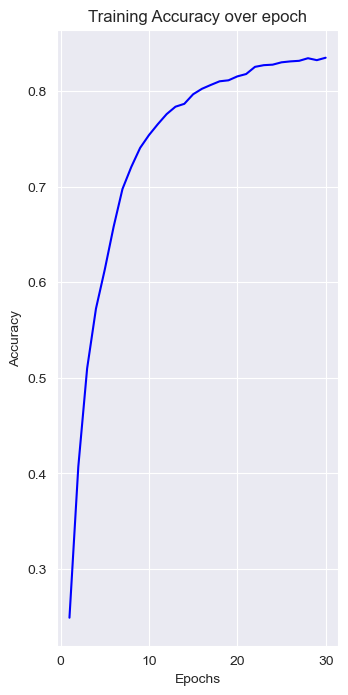

In [50]:
# access the accuracy and loss from history object
acc = history.history['accuracy']
loss = history.history['loss']


#Generate the range of epochs
epochs_range = range(1, len(acc)+1)

# plot the accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over epoch")
plt.show()

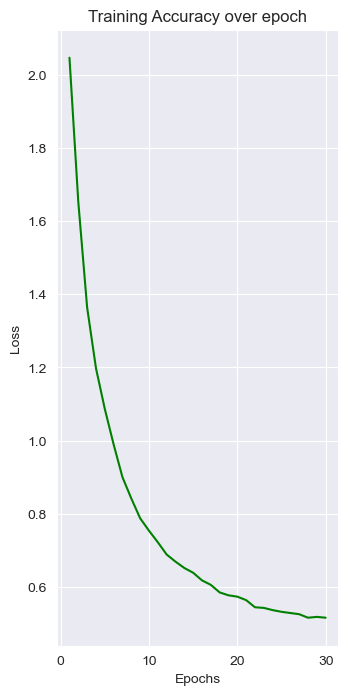

In [51]:
# plot the loss
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, loss, label='Training Loss', color='g')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Accuracy over epoch")
plt.show()

11. Testing 

11.1 Reshaping 

In [52]:
testing_data = np.reshape(testing_data,(-1, 28, 28, 1))

11.2 Normalizing

In [53]:
testing_data = testing_data.astype('float32') / 255.0

12. Prediction

In [56]:
prediction = new_model.predict(testing_data)

875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


12.0 Submission

In [57]:
result = np.argmax(prediction, axis=1)
result = pd.Series(result, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name="ImageID"), result], axis=1)
submission.to_csv('/Users/godfreykrutzsch/Desktop/digit-recognizer/submission_revise_11.csv', index=False)